In [1]:
from qiskit.transpiler.passes import CountOpsLongestPath
import sys
sys.path.append("..")
import fakeutils
from mock_backend import FakeHatlab
from qiskit.transpiler import PassManager
from qiskit import QuantumCircuit
import numpy as np
from fakeutils.equivalence_library import SessionEquivalenceLibrary
_sel = SessionEquivalenceLibrary
from qiskit import transpile
from cost_analysis_pass import DurationCriticalPath
from fakeutils.basis_translator import BasisTranslator
from NuOp.parallel_two_qubit_gate_decomposition import ParallelGateReplacementPass
from itertools import product
from fakeutils.riswap import RiSwapGate
import numpy as np
from mock_backend.fake_surfaceCode import FakeSurfaceCode
from qiskit.transpiler.passes import BasicSwap, Optimize1qGates, Optimize1qGatesDecomposition
from fakeutils.nonglobal_trivial_layout import NonGlobalTrivialLayout
from fakeutils.weyl_decompose import RootiSwapWeylDecomposition
from fakeutils.gate_map import *

In [2]:
from pass_manager import level_0_pass_manager

In [3]:
# # # # from qiskit.circuit.random import random_circuit
# # # # qc = random_circuit(3, 3, measure=False)
# # # # qc.draw(output='mpl')

# qc = QuantumCircuit(4)
# # # # qc.x(0)
# # # # qc.swap(0,2)
# # # # qc.cx(1,0)
# # # # qc.x(1)
# # # # qc.rz(np.pi/2, 2)
# # # # qc.rx(np.pi/2, 2)
# # # # qc.rz(np.pi/2, 2)
# # # # qc.cx(0,7)

# # # # qc.cx(2,5)

# # # qc.cx(0,3)
# qc = random_circuit(5, 5, max_operands=2, measure=False)
# # qc.rzz(np.pi, 0 ,1)
# # qc.cu3(np.pi/2, np.pi/3, np.pi/4, 0,1)
# # qc.id(0)
# # qc.draw(output='mpl')

NameError: name 'random_circuit' is not defined

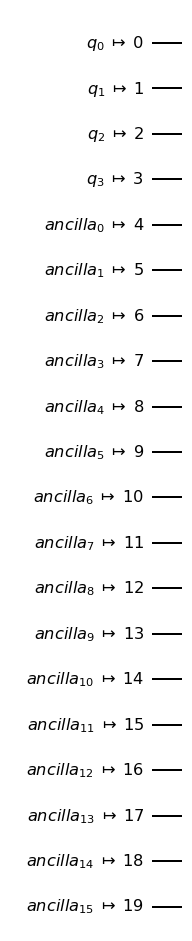

In [4]:
backendrswap = FakeSurfaceCode(twoqubitgate="iswap")
pm_rswap = level_0_pass_manager(backendrswap, decomp_method='weyl', decompose_swaps=True, critical_path_only=False)
pm_rswap.run(qc).draw(output='mpl')

In [ ]:
backend = FakeSurfaceCode(twoqubitgate="cx")
#backend = FakeHatlab()
from fakeutils.gate_map import plot_gate_map
#plot_gate_map(backend, qubit_coordinates=backend.qubit_coordinates)
plot_gate_map(backend)

Test FakeSurfaceCode topology (all to all, global ops)

1. with native gateset X,sqrtX, Y, sqrtY, RZ, CX

2. with native gateset X, sqrtX, Y, sqrtY, RZ, riSwap
    - transpile using weyl chamber
    - transpile using numerical optimization

In [ ]:
def qft_rotations(circuit, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        circuit.cp(np.pi/2**(n-qubit), qubit, n)
    # At the end of our function, we call the same function again on
    # the next qubits (we reduced n by one earlier in the function)
    qft_rotations(circuit, n)
    
def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit
def inverse_qft(circuit, n):
    """Does the inverse QFT on the first n qubits in circuit"""
    # First we create a QFT circuit of the correct size:
    qft_circ = qft(QuantumCircuit(n), n)
    # Then we take the inverse of this circuit
    invqft_circ = qft_circ.inverse()
    # And add it to the first n qubits in our existing circuit
    circuit.append(invqft_circ, circuit.qubits[:n])
    return circuit.decompose() # .decompose() allows us to see the individual gates

def getQFTCircuit(nqubits=4, number=5):
    qc = QuantumCircuit(nqubits)
    for qubit in range(nqubits):
        qc.h(qubit)
    qc.p(number*np.pi/4,0)
    qc.p(number*np.pi/2,1)
    qc.p(number*np.pi,2)

    qc = inverse_qft(qc, nqubits)
    qc.measure_all()
    return qc

qc = getQFTCircuit(4,4)
qc.draw(output='mpl')

In [ ]:
backend = FakeSurfaceCode(twoqubitgate="cx")
#backend = FakeHatlab()
pm = level_0_pass_manager(backend, decomp_method='cx', decompose_swaps=True, critical_path_only=False)
trans_circ = pm.run(qc)
print("Critical path duration", pm.property_set["duration_longest_path_length"], "seconds")
trans_circ.draw(output='mpl')

Critical path duration 0.0 seconds


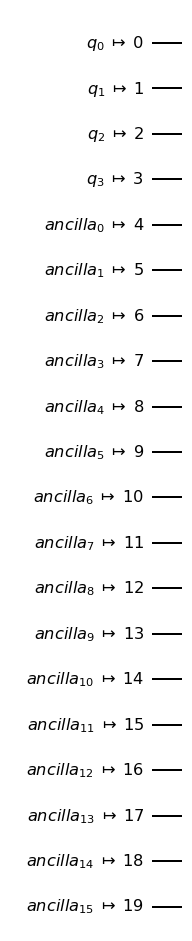

In [5]:
backend = FakeSurfaceCode(twoqubitgate="iswap")
#backend = FakeHatlab()
pm = level_0_pass_manager(backend, decomp_method='weyl', decompose_swaps=True, critical_path_only=False)
trans_circ = pm.run(qc)
print("Critical path duration", pm.property_set["duration_longest_path_length"], "seconds")
trans_circ.draw(output='mpl')

In [7]:
qc = QuantumCircuit(2)
qc.swap(0,1)

Critical path duration None seconds


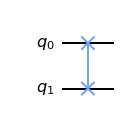

In [11]:
backend = FakeSurfaceCode(twoqubitgate="iswap")
#pm = level_0_pass_manager(backend, decomp_method='nuop', decompose_swaps=True, critical_path_only=False)
pm = PassManager()
fid_2q = dict.fromkeys(
            [(i, j) for i, j in product(range(backend.num_qubits), repeat=2) if i != j],
            [1],
        )
swap_change = ParallelGateReplacementPass(
    [RiSwapGate],
    [[1 / 2]],
    fid_2q,
    [1 for _ in range(54)],
    tol=0.0000001,
    decompose_swaps=True,
)
pm.append(swap_change)
trans_circ = pm.run(qc)
print("Critical path duration", pm.property_set["duration_longest_path_length"], "seconds")
trans_circ.draw(output='mpl')

In [ ]:
#make a plot :)
backendcx = FakeSurfaceCode(twoqubitgate="cx")
pm_cx = level_0_pass_manager(backendcx, decomp_method='cx', decompose_swaps=True, critical_path_only=False)

backendrswap = FakeSurfaceCode(twoqubitgate="iswap")
pm_rswap = level_0_pass_manager(backendrswap, decomp_method='weyl', decompose_swaps=True, critical_path_only=False)

cx_times = []
riswap_times = []

q_list = range(4, 16)
for q in q_list:
    #crete new QFT circuit of variable qubit size
    qc = getQFTCircuit(q,4)

    #data cx
    pm_cx.run(qc)
    cx_times.append(pm_cx.property_set["duration_longest_path_length"])

    #data riswap
    pm_rswap.run(qc)
    riswap_times.append(pm_rswap.property_set["duration_longest_path_length"])

import matplotlib.pyplot as plt
plt.plot(q_list, cx_times, '-o', label="cx")
plt.plot(q_list, riswap_times, '-o', label="riswap")
plt.xlabel("QFT on n qubits")
plt.ylabel("circuit duration (s)")
plt.legend()

In [ ]:
from qiskit.circuit.library import QuantumVolume

#make a plot :)
backendcx = FakeSurfaceCode(twoqubitgate="cx")
pm_cx = level_0_pass_manager(backendcx, decomp_method='cx', decompose_swaps=True, critical_path_only=False)

backendrswap = FakeSurfaceCode(twoqubitgate="iswap")
pm_rswap = level_0_pass_manager(backendrswap, decomp_method='weyl', decompose_swaps=True, critical_path_only=False)

cx_times = []
riswap_times = []

q_list = range(4, 16)
for q in q_list:
    #crete new variable size quantum volume circuit
    qc = QuantumVolume(q, 4, 42).decompose().decompose()

    #data cx
    pm_cx.run(qc)
    cx_times.append(pm_cx.property_set["duration_longest_path_length"])

    #data riswap
    pm_rswap.run(qc)
    riswap_times.append(pm_rswap.property_set["duration_longest_path_length"])

import matplotlib.pyplot as plt
plt.plot(q_list, cx_times, '-o', label="cx")
plt.plot(q_list, riswap_times, '-o', label="riswap")
plt.xlabel("Quantum Volume on n qubits, depth 4")
plt.ylabel("circuit duration (s)")
plt.legend()

In [ ]:
plot_gate_map(FakeSurfaceCode(twoqubitgate="cx"))

In [ ]:
from qiskit.circuit.random import random_circuit

#make a plot :)
backendcx = FakeSurfaceCode(twoqubitgate="cx")
pm_cx = level_0_pass_manager(backendcx, decomp_method='cx', decompose_swaps=True, critical_path_only=False)

backendrswap = FakeSurfaceCode(twoqubitgate="iswap")
pm_rswap = level_0_pass_manager(backendrswap, decomp_method='weyl', decompose_swaps=True, critical_path_only=False)

cx_times = []
riswap_times = []

q_list = range(4, 16)
for q in q_list:
    print(q)
    #crete new variable size quantum volume circuit
    qc = random_circuit(q, q, measure=False, max_operands=2)

    #data cx
    pm_cx.run(qc)
    cx_times.append(pm_cx.property_set["duration_longest_path_length"])

    #data riswap
    pm_rswap.run(qc)
    riswap_times.append(pm_rswap.property_set["duration_longest_path_length"])

import matplotlib.pyplot as plt
plt.plot(q_list, cx_times, '-o', label="cx")
plt.plot(q_list, riswap_times, '-o', label="riswap")
plt.xlabel("(n qubits, n depth) Randomized Circuit")
plt.ylabel("circuit duration (s)")
plt.legend()